In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# !pip install xgboost
# !pip install tensorflow

# PREDICT THE BURNED AREA OF FOREST FIRES WITH NEURAL NETWORKS


In [3]:
import pandas as pd 
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [4]:
forest = pd.read_csv('forestfires.csv')
forest

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,...,0,0,0,0,0,0,0,0,0,large
513,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,...,0,0,0,0,0,0,0,0,0,large
514,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,...,0,0,0,0,0,0,0,0,0,large
515,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,...,0,0,0,0,0,0,0,0,0,small


# About DataSet

month - month of the year: 'jan' to 'dec'
    
day - day of the week: 'mon' to 'sun'

FFMC - FFMC index from the FWI system: 18.7 to 96.20

DMC - DMC index from the FWI system: 1.1 to 291.3

DC - DC index from the FWI system: 7.9 to 860.6
    
ISI - ISI index from the FWI system: 0.0 to 56.10

temp - temperature in Celsius degrees: 2.2 to 33.30

RH - relative humidity in %: 15.0 to 100
    
wind - wind speed in km/h: 0.40 to 9.40

rain - outside rain in mm/m2 : 0.0 to 6.4
    
area - the burned area of the forest (in ha): 0.00 to 1090.84
**(this output variable is very skewed towards 0.0, thus it may make
sense to model with the logarithm transform)**

The Fine Fuel Moisture Code (FFMC) represents fuel moisture of forest litter fuels under the shade of a forest canopy. It is intended to represent moisture conditions for shaded litter fuels, the equivalent of 16-hour timelag. It ranges from 0-101. Subtracting the FFMC value from 100 can provide an estimate for the equivalent (approximately 10h) fuel moisture content, most accurate when FFMC values are roughly above 80.

The Duff Moisture Code (DMC) represents fuel moisture of decomposed organic material underneath the litter. System designers suggest that it is represents moisture conditions for the equivalent of 15-day (or 360 hr) timelag fuels. It is unitless and open ended. It may provide insight to live fuel moisture stress.

The Drought Code (DC), much like the Keetch-Byrum Drought Index, represents drying deep into the soil. It approximates moisture conditions for the equivalent of 53-day (1272 hour) timelag fuels. It is unitless, with a maximum value of 1000. Extreme drought conditions have produced DC values near 800.

## EDA

In [5]:
# Checking Null Values and DType

forest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  dayfri         517 non-null    int64  
 12  daymon         517 non-null    int64  
 13  daysat         517 non-null    int64  
 14  daysun         517 non-null    int64  
 15  daythu         517 non-null    int64  
 16  daytue         517 non-null    int64  
 17  daywed         517 non-null    int64  
 18  monthapr  

**No Null Values in Dataset**

In [6]:
# Checking Duplicate Values

forest[forest.duplicated()]

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
53,aug,wed,92.1,111.2,654.1,9.6,20.4,42,4.9,0.0,...,0,0,0,0,0,0,0,0,0,small
100,aug,sun,91.4,142.4,601.4,10.6,19.8,39,5.4,0.0,...,0,0,0,0,0,0,0,0,0,small
215,mar,sat,91.7,35.8,80.8,7.8,17.0,27,4.9,0.0,...,0,0,0,0,1,0,0,0,0,large
303,jun,fri,91.1,94.1,232.1,7.1,19.2,38,4.5,0.0,...,0,0,0,1,0,0,0,0,0,small
426,aug,thu,91.6,248.4,753.8,6.3,20.4,56,2.2,0.0,...,0,0,0,0,0,0,0,0,0,small
461,aug,sat,93.7,231.1,715.1,8.4,18.9,64,4.9,0.0,...,0,0,0,0,0,0,0,0,0,small
501,aug,tue,96.1,181.1,671.2,14.3,21.6,65,4.9,0.8,...,0,0,0,0,0,0,0,0,0,small
508,aug,fri,91.0,166.9,752.6,7.1,25.9,41,3.6,0.0,...,0,0,0,0,0,0,0,0,0,small


In [7]:
forest[forest.duplicated()].shape

(8, 31)

In [8]:
# Removing Duplicate Values

forest.drop_duplicates(inplace=True)

In [9]:
forest[forest.duplicated()]

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category


**We have droped all Dulpicate values from data**

# Visualization

In [10]:
import matplotlib.pyplot as plt

**DMC compared to FFMC**

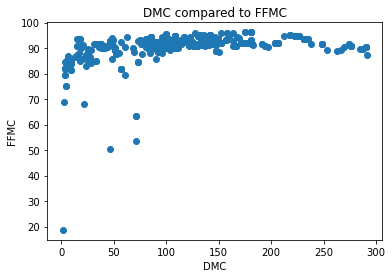

In [11]:
plt.scatter(x=forest.DMC, y=forest.FFMC)
plt.xlabel('DMC')
plt.ylabel('FFMC')
plt.title('DMC compared to FFMC')
plt.show()

### Bar Graph 

**How many fires have occurred on each day**

In [12]:
import seaborn as sns

print(forest['day'].value_counts())

sun    94
fri    83
sat    82
mon    74
tue    63
thu    60
wed    53
Name: day, dtype: int64


Text(0.5, 1.0, 'Occurances of Fires by Weekday')

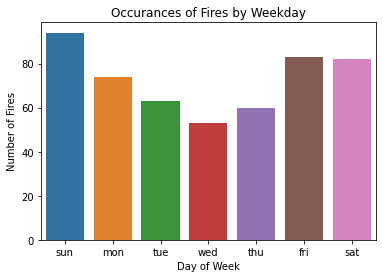

In [13]:
fig = sns.barplot(x=forest.day.value_counts().index, y=forest.day.value_counts(), order=['sun', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat'])
fig.set_xlabel('Day of Week')
fig.set_ylabel('Number of Fires')
fig.set_title('Occurances of Fires by Weekday')

**On Sundays there was more fire compared to other Days**

### As the output variable is very skewed towards 0.0, thus it may make sense to model with the logarithm transform

### Log Transformation on area

In [14]:
forest['area_log'] = np.where(forest['area'] ==  0, 0, np.log(forest['area']))
forest

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category,area_log
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,1,0,0,0,0,small,0.000000
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,1,0,small,0.000000
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,1,0,small,0.000000
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,1,0,0,0,0,small,0.000000
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,1,0,0,0,0,small,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,...,0,0,0,0,0,0,0,0,large,1.862529
513,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,...,0,0,0,0,0,0,0,0,large,3.994340
514,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,...,0,0,0,0,0,0,0,0,large,2.412336
515,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,...,0,0,0,0,0,0,0,0,small,0.000000


In [15]:
## Only Negetive ones

only_negs = forest.loc[forest['area_log'] < 0]
only_negs

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category,area_log
138,jul,tue,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,...,0,1,0,0,0,0,0,0,small,-1.021651
139,sep,tue,91.0,129.5,692.6,7.0,21.7,38,2.2,0.0,...,0,0,0,0,0,0,0,1,small,-0.843970
140,sep,mon,90.9,126.5,686.5,7.0,21.9,39,1.8,0.0,...,0,0,0,0,0,0,0,1,small,-0.755023
141,aug,wed,95.5,99.9,513.3,13.2,23.3,31,4.5,0.0,...,0,0,0,0,0,0,0,0,small,-0.597837
142,aug,fri,90.1,108.0,529.8,12.5,21.2,51,8.9,0.0,...,0,0,0,0,0,0,0,0,small,-0.494296
143,jul,sat,90.0,51.3,296.3,8.7,16.6,53,5.4,0.0,...,0,1,0,0,0,0,0,0,small,-0.342490
144,aug,wed,95.5,99.9,513.3,13.2,23.8,32,5.4,0.0,...,0,0,0,0,0,0,0,0,small,-0.261365
145,aug,thu,95.2,131.7,578.8,10.4,27.4,22,4.0,0.0,...,0,0,0,0,0,0,0,0,small,-0.105361
146,mar,mon,90.1,39.7,86.6,6.2,13.2,40,5.4,0.0,...,0,0,0,1,0,0,0,0,small,-0.051293
147,sep,tue,84.4,73.4,671.9,3.2,24.2,28,3.6,0.0,...,0,0,0,0,0,0,0,1,small,-0.040822


In [16]:
target_dataset = forest[['FFMC','DMC','DC','ISI','temp','RH','wind','rain','area_log']]

In [17]:
target_dataset 

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area_log
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.000000
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.000000
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.000000
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.000000
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
512,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,1.862529
513,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,3.994340
514,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,2.412336
515,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.000000


## Model Building

**1) XGBoost**

In [18]:
import xgboost as xgb

In [19]:
XTarget, yLabel = target_dataset.iloc[:,:-1],target_dataset.iloc[:,-1]

print(XTarget)
print(yLabel)


     FFMC    DMC     DC   ISI  temp  RH  wind  rain
0    86.2   26.2   94.3   5.1   8.2  51   6.7   0.0
1    90.6   35.4  669.1   6.7  18.0  33   0.9   0.0
2    90.6   43.7  686.9   6.7  14.6  33   1.3   0.0
3    91.7   33.3   77.5   9.0   8.3  97   4.0   0.2
4    89.3   51.3  102.2   9.6  11.4  99   1.8   0.0
..    ...    ...    ...   ...   ...  ..   ...   ...
512  81.6   56.7  665.6   1.9  27.8  32   2.7   0.0
513  81.6   56.7  665.6   1.9  21.9  71   5.8   0.0
514  81.6   56.7  665.6   1.9  21.2  70   6.7   0.0
515  94.4  146.0  614.7  11.3  25.6  42   4.0   0.0
516  79.5    3.0  106.7   1.1  11.8  31   4.5   0.0

[509 rows x 8 columns]
0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
512    1.862529
513    3.994340
514    2.412336
515    0.000000
516    0.000000
Name: area_log, Length: 509, dtype: float64


In [20]:
# for xgboost

data_dmatrix = xgb.DMatrix(data=XTarget,label=yLabel)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(XTarget, yLabel, test_size=0.2, random_state=123)

In [22]:
# using regressor since we are using regression against area

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [23]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

[16:21:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


**RMSE**

In [24]:
from sklearn.metrics import mean_squared_error

In [25]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 1.433150


### xgboost.cv: 
#### Simply a convenience function for performing Kfold cross-validation

In [26]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[16:21:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:21:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:21:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [27]:
cv_results


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1.499513,0.030239,1.499348,0.060289
1,1.486035,0.030167,1.489769,0.060975
2,1.475912,0.030240,1.481128,0.061740
3,1.466335,0.029363,1.474340,0.061666
4,1.457368,0.029439,1.469299,0.060866
5,1.448814,0.031405,1.465044,0.061284
6,1.440958,0.031350,1.461332,0.061140
7,1.436070,0.032133,1.458617,0.061548
8,1.429423,0.033709,1.455015,0.060719
9,1.424501,0.032228,1.452718,0.060344


In [28]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[16:21:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


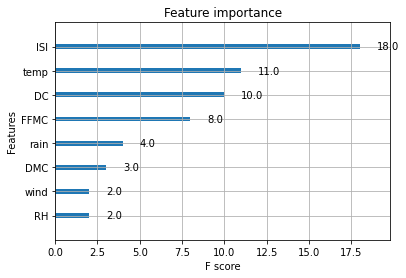

In [29]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

### Train-Test_Split

In [30]:
train_dataset = target_dataset.sample(frac=0.8, random_state=0)
test_dataset = target_dataset.drop(train_dataset.index)

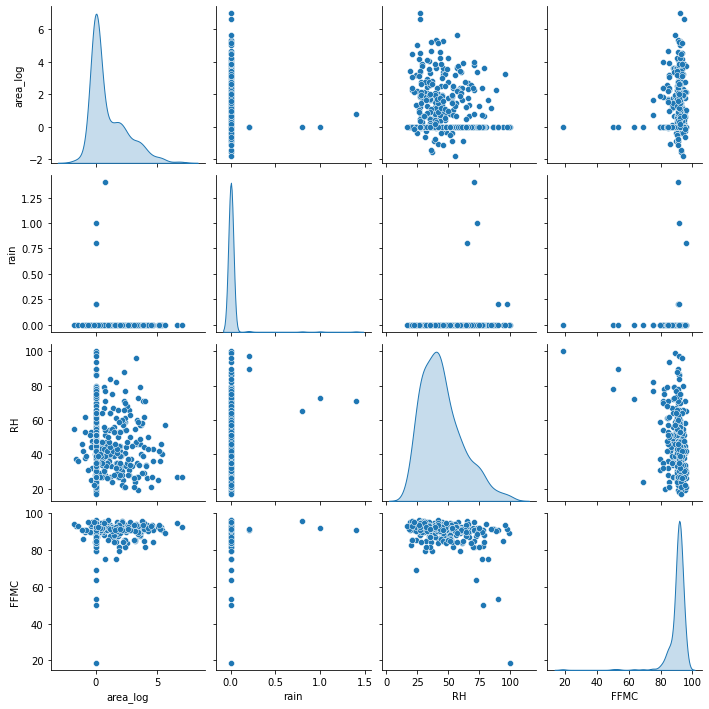

In [31]:
sns.pairplot(train_dataset[['area_log', 'rain', 'RH', 'FFMC']], diag_kind='kde')

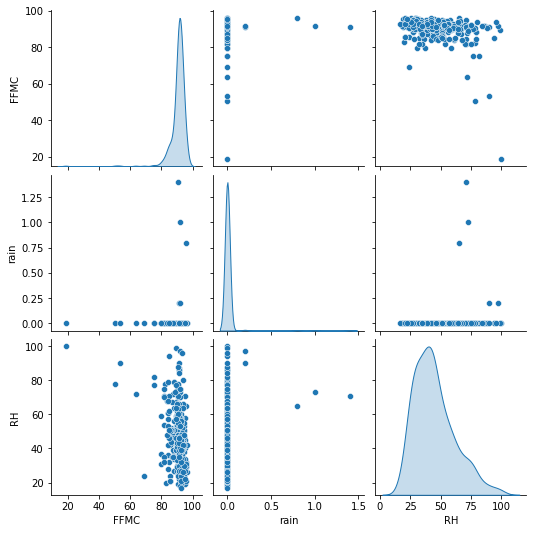

In [32]:
sns.pairplot(train_dataset[['FFMC', 'rain', 'RH']], diag_kind='kde')

In [33]:
train_dataset.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
FFMC,407.0,90.448649,5.771669,18.700000,90.2,91.6,92.500000,96.200000
DMC,407.0,107.355528,61.822250,1.100000,56.7,105.8,139.400000,291.300000
DC,407.0,543.258231,251.729862,7.900000,417.6,664.5,714.300000,860.600000
ISI,407.0,8.892383,4.723687,0.000000,6.3,8.2,10.500000,56.100000
temp,407.0,18.591155,5.758025,4.200000,15.4,19.1,22.550000,32.600000
RH,407.0,44.803440,16.666851,17.000000,33.0,42.0,54.000000,100.000000
wind,407.0,4.046437,1.808323,0.400000,2.7,4.0,5.400000,9.400000
rain,407.0,0.008845,0.094792,0.000000,0.0,0.0,0.000000,1.400000
area_log,407.0,0.985679,1.464026,-1.771957,0.0,0.0,1.855501,6.994703


array([[<AxesSubplot:title={'center':'area_log'}>]], dtype=object)

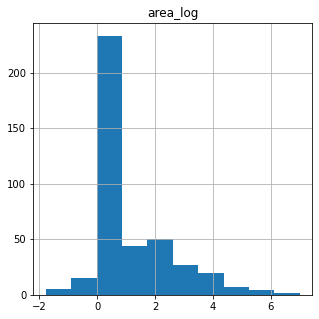

In [34]:
train_dataset.hist(column='area_log')


In [35]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('area_log')
test_labels = test_features.pop('area_log')

In [36]:
train_dataset.describe().transpose()[['mean', 'std']]


,mean,std
FFMC,90.448649,5.771669
DMC,107.355528,61.822250
DC,543.258231,251.729862
ISI,8.892383,4.723687
temp,18.591155,5.758025
RH,44.803440,16.666851
wind,4.046437,1.808323
rain,0.008845,0.094792
area_log,0.985679,1.464026


### Normalising data

In [37]:
normalizer = tf.keras.layers.Normalization(axis=-1)


In [38]:
normalizer.adapt(np.array(train_features))

In [39]:
print(normalizer.mean.numpy())


[[9.0448662e+01 1.0735554e+02 5.4325818e+02 8.8923836e+00 1.8591152e+01
  4.4803440e+01 4.0464377e+00 8.8452091e-03]]


In [40]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[91.7 35.8 80.8  7.8 17.4 24.   5.4  0. ]]

Normalized: [[ 0.22 -1.16 -1.84 -0.23 -0.21 -1.25  0.75 -0.09]]


### Linear Regression

In [41]:
dmc = np.array(train_features['DMC'])

dmc_normalizer = layers.Normalization(input_shape=[1,], axis=None)
dmc_normalizer.adapt(dmc)

In [42]:
dmc_model = tf.keras.Sequential([
    dmc_normalizer,
    layers.Dense(units=1)
])

dmc_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [43]:
dmc_model.predict(dmc[:10])


1/1 [==============================] - 0s 69ms/step


array([[ 1.4235467 ],
       [ 0.30946645],
       [-0.8046137 ],
       [ 1.6304473 ],
       [ 1.2663819 ],
       [-0.6733113 ],
       [ 0.3194136 ],
       [-1.2402986 ],
       [ 0.34527624],
       [-0.44054818]], dtype=float32)

In [44]:
dmc_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [45]:
%%time
history = dmc_model.fit(
    train_features['DMC'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: total: 3.39 s
Wall time: 8.44 s


In [46]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,val_loss,epoch
0,1.367948,1.158772,0
1,1.121666,1.093407,1
2,1.094133,1.094103,2
3,1.063113,1.071728,3
4,1.062187,1.058800,4
...,...,...,...
95,1.066242,1.062525,95
96,1.072447,1.070470,96
97,1.068310,1.078487,97
98,1.060400,1.065650,98


In [47]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 5])
  plt.xlabel('Epoch')
  plt.ylabel('Error [DMC]')
  plt.legend()
  plt.grid(True)

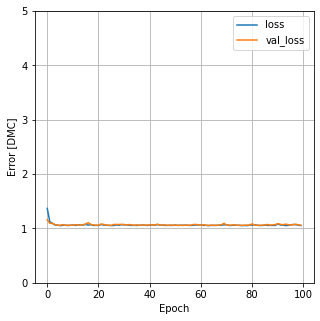

In [48]:
plot_loss(history)

In [49]:
test_results = {}

test_results['dmc_model'] = dmc_model.evaluate(
    test_features['DMC'],
    test_labels, verbose=0)

In [50]:
x = tf.linspace(0.0, 250, 251)
y = dmc_model.predict(x)

8/8 [==============================] - 0s 2ms/step


In [51]:
def plot_dmc(x, y):
  plt.scatter(train_features['DMC'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('DMC')
  plt.ylabel('area')
  plt.legend()

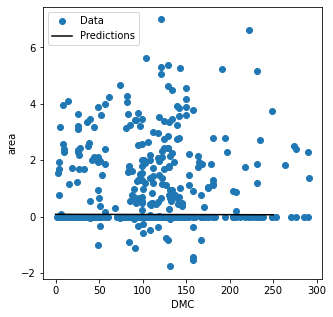

In [52]:
plot_dmc(x, y)


In [53]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [54]:
linear_model.predict(train_features[:10])


1/1 [==============================] - 0s 88ms/step


array([[-0.11491659],
       [ 0.00522116],
       [ 0.25519493],
       [-0.38962522],
       [-1.403157  ],
       [-1.1445639 ],
       [-0.4758275 ],
       [-0.4145622 ],
       [ 0.91078794],
       [ 0.11444687]], dtype=float32)

In [55]:
linear_model.layers[1].kernel


<tf.Variable 'dense_1/kernel:0' shape=(8, 1) dtype=float32, numpy=
array([[-0.5538432 ],
       [ 0.30187595],
       [-0.75139534],
       [-0.176193  ],
       [-0.15464133],
       [ 0.72958064],
       [-0.2519307 ],
       [-0.00853521]], dtype=float32)>

In [56]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [57]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: total: 3.62 s
Wall time: 7.51 s


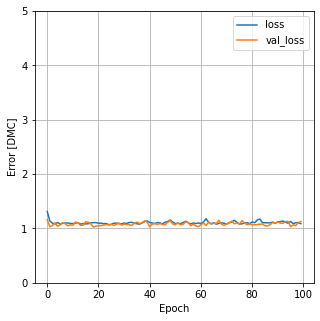

In [58]:
plot_loss(history)


In [59]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

### DNN

In [60]:
def build_and_compile_model(norm):
  model = tf.keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [61]:
dnn_dmc_model = build_and_compile_model(dmc_normalizer)

In [62]:
dnn_dmc_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [63]:
print(len(train_features))

407


In [64]:
%%time
history = dnn_dmc_model.fit(
    train_features['DMC'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 3.88 s
Wall time: 8.43 s


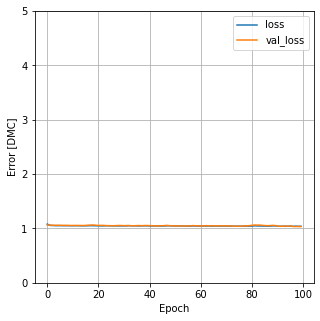

In [65]:
plot_loss(history)


In [66]:
x = tf.linspace(0.0, 50, 51)
y = dnn_dmc_model.predict(x)


2/2 [==============================] - 0s 2ms/step


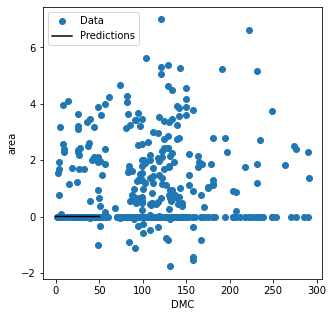

In [67]:
plot_dmc(x, y)

In [68]:
test_results['dnn_dmc_model'] = dnn_dmc_model.evaluate(
    test_features['DMC'], test_labels,
    verbose=0)

In [69]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 8)                17        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                576       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,818
Trainable params: 4,801
Non-trainable params: 17
_________________________________________________________________


In [70]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=200)

CPU times: total: 6.95 s
Wall time: 14.9 s


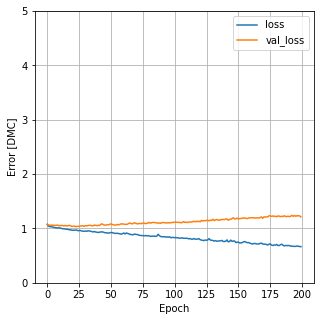

In [71]:
plot_loss(history)


In [72]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [73]:
pd.DataFrame(test_results, index=['Mean absolute error [area_log]']).T

,Mean absolute error [area_log]
dmc_model,1.023962
linear_model,1.118694
dnn_dmc_model,1.044150
dnn_model,1.095037
